# Interpolation Testing

This notebook tests interpolation of pollutant concentrations using nearby sensor data collected through [OpenAQ](https://openaq.org/). The first thing we need to do is add the project root to our path, so that Python knows where to find our `PredictPollutant` function, which we'll be using to predict pollutant concentrations later in this notebook.

In [9]:
# Adding project root to the path in order to enable imports from sibling directories
import os
import sys

sys.path.append(os.path.abspath('..'))

Next, we import all of the modules we'll need to use in this notebook:

In [10]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from analysis.idw_interpolation import PredictPollutant, ParityPlot

Now that we have all of the modules we'll need loaded, we start by loading in one month of pollutant data collected from OpenAQ. The data loaded here is from January, but the `raw_data` directory contains data from other months of the year as well, and we'll look at the rest of this data later. We first use Pandas to read our CSV file and turn it into a DataFrame. We then filter for rows containing PM2.5 data on January 1st, 2020 at 08:00 UTC in a DataFrame named 'filtered_df', and we use the len function to see how many rows of data are in the filtered DataFrame.

In [11]:
# Load in one month of data for testing
df = pd.read_csv('../raw_data/maryland_data_2020_01.csv')

# Filter data for PM2.5 on January 1st, 2020 at 08:00 UTC
pollutant = 'pm25'
year = 2020
month = 1
day = 1
hour = 8

filtered_df = df[
    (df['parameter'] == pollutant) &
    (df['year'] == year) &
    (df['month'] == month) &
    (df['day'] == day) &
    (df['hour'] == hour)
]

print(f'The filtered DataFrame contains {len(filtered_df)} rows.')

The filtered DataFrame contains 25 rows.


We see that we have 25 rows in our filtered DataFrame. We can now make PM2.5 predictions using this data and our `PredictPollutant` function, which performs inverse distance weighting (IDW) interpolation to make predictions. In order to determine the accuracy of this interpolation method, we can make predictions of what the pollutant concentration should be in locations where we know the pollutant concentration. To do this, we create two empty lists to store the true and predicted PM2.5 concentrations. For each row in our filtered DataFrame, we take the coordinates of a location along with the true PM2.5 value at that location. We then temporarily remove that row from the DataFrame and perform IDW interpolation to predict the PM2.5 concentration using the four nearest sensors, and add the value to our predicted values list.

In [12]:
# Create lists to store true and predicted PM2.5 concentration for each location
true_vals = []
predicted_vals = []

# Loop through all of the rows in the filtered DataFrame
for idx, row in filtered_df.iterrows():
    # Retrieve the latitude, longitude, and PM2.5 concentration of the current row
    lat = row['latitude']
    lon = row['longitude']
    true_val = row['value']
    coords = (lat, lon)

    # Create a temporary DataFrame without the current row
    df_temp = filtered_df.drop(index=idx)

    # Use inverse distance weighting interpolation to find the predicted concentration at the coordinates of the current row
    try:
        prediction = PredictPollutant(df_temp, coords, n_sensors=4,
                                      pollutant=pollutant, year=2020, month=1, day=1, hour=8)
        true_vals.append(true_val)
        predicted_vals.append(prediction)
    except Exception as e:
        print(f'Skipping index {idx} due to error: {e}')

Now that we have the true and predicted PM2.5 concentration at all 25 locations, we want to visualize how accurate this method was for the day and hour selected. We can do this by creating a parity plot, which plots the actual PM2.5 concentration on the x-axis vs. the predicted PM2.5 concentration on the y-axis. Points closer to the diagonal line are better predictions, while points further from the line are worse predictions. We can also compute several statistics on the predictions, such as the mean absolute error (MAE), the root mean squared error (RMSE), and the $R^2$ values.

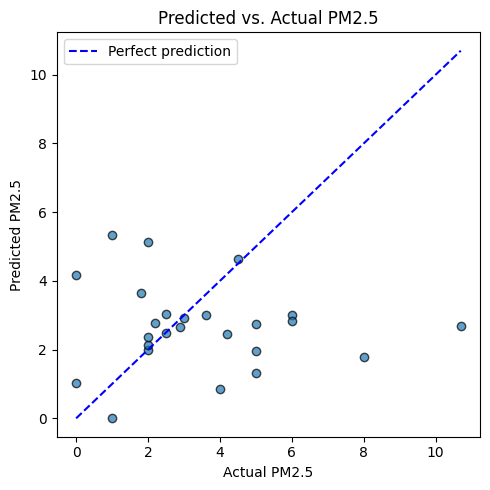

Mean Absolute Error (MAE): 2.0967
Root Mean Squared Error (RMSE): 2.9332
R² Score: -0.4705


In [13]:
# Create a visualization of the true vs. predicted values
plt.figure(figsize=(5, 5))
plt.scatter(true_vals, predicted_vals, alpha=0.7, edgecolors='k')
plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'b--', label='Perfect prediction')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Predicted vs. Actual PM2.5')
plt.legend()
plt.tight_layout()
plt.show()

# Compute metrics
mae = mean_absolute_error(true_vals, predicted_vals)
rmse = np.sqrt(mean_squared_error(true_vals, predicted_vals))
r2 = r2_score(true_vals, predicted_vals)

# Print results
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

As seen on the graph, the predictions produced using this method for PM2.5 are not very accurate. Next, we will perform the same procedure to predict O3 concentration for all of the known locations. This time, we use a function named `ParityPlot` to achieve the same analysis as shown for PM2.5.

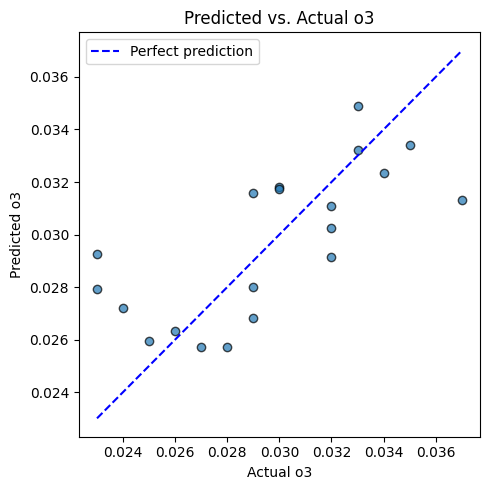

Mean Absolute Error (MAE): 0.0023
Root Mean Squared Error (RMSE): 0.0028
R² Score: 0.5006


In [17]:
# Use the ParityPlot function to analyze the accuracy of predictions for O3 on January 1st, 2020 at 08:00 UTC
ParityPlot(df, 'o3', 2020, 1, 1, 8)

As seen in this graph, the O3 predictions are more accurate than the previous predictions produced in the PM2.5 example. However, these predictions are just for two pollutants at one hour out of the year, and this may not be representative of the accuracy of these predictions across the entire year and for all pollutants. Next, we will analyze the accuracy of predictions for every day in one year, and for all pollutants reported by OpenAQ sensors.